In [1]:
import numpy as np

from scipy.stats import norm

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import time
import math
import os
import gzip

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc. and display plots
from functions.market.features import *
from functions.market.plots import *
from functions.preprocessing import *
from functions.evaluation import *

from TestEnvironment import TestEnvironment

In [2]:
np.random.seed(1234)

te = TestEnvironment()

# Dataprep

Dataset size: 42700
Depth: 20

Label distribution in the whole dataset:
UP labels: 14610 	 34.21545667447307%
NO_MOVE labels: 14484 	 33.92037470725995%
DOWN labels: 13606 	 31.86416861826698%


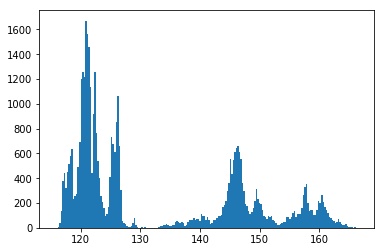

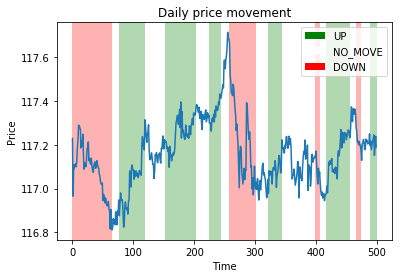

In [3]:
dataset_name = "eth_eur_d20_lw30_sw100_l3.npy.gz"

with gzip.GzipFile("data/kraken/" + dataset_name, "r") as file:
    dataset = np.load(file)
    
lob_depth = int(len(dataset["snapshot"][0])/2)

print("Dataset size:", len(dataset))
print("Depth:", lob_depth)
print()
print("Label distribution in the whole dataset:")
count_labels(dataset["label"])

plt.hist(dataset["vwap"], bins=200)
plot_labels(dataset["vwap"][:500], dataset["label"][:500])
plt.show()

In [4]:
# sort labels for the equalization
ups = dataset[np.where(dataset["label"] == 1)]
nomoves = dataset[np.where(dataset["label"] == 0)]
downs = dataset[np.where(dataset["label"] == -1)]

# to equalize number of labels in the dataset use the lowest number
n_samples_per_label = np.min([len(ups), len(nomoves), len(downs)])

In [5]:
# train-test split
test_split = 0.2

ups_train, ups_test         = train_test_split(ups, test_size=test_split, random_state=42, shuffle = False, stratify = None)
nomoves_train, nomoves_test = train_test_split(nomoves, test_size=test_split, random_state=42, shuffle = False, stratify = None)
downs_train, downs_test     = train_test_split(downs, test_size=test_split, random_state=42, shuffle = False, stratify = None)

In [6]:
# shuffle before selecting by the n_samples_per_label 
# (to avoid not using any data from the last section of the bigger sets)
np.random.shuffle(ups_train)
np.random.shuffle(ups_test)

np.random.shuffle(nomoves_train)
np.random.shuffle(nomoves_test)

np.random.shuffle(downs_train)
np.random.shuffle(downs_test)

In [7]:
# create the mixed train and test sets
train = np.concatenate(
     (ups_train[:int(n_samples_per_label*(1-test_split))], 
     nomoves_train[:int(n_samples_per_label*(1-test_split))], 
     downs_train[:int(n_samples_per_label*(1-test_split))])
)

test = np.concatenate(
     (ups_test[:int(n_samples_per_label*(test_split))], 
     nomoves_test[:int(n_samples_per_label*(test_split))], 
     downs_test[:int(n_samples_per_label*(test_split))])
)

In [8]:
# shuffle to mix labels
np.random.shuffle(train)
np.random.shuffle(test)

In [9]:
# input
X_train = train['snapshot'][:,:,0:2]
X_test = test['snapshot'][:,:,0:2]

# reshape (flatten)
X_train = X_train.reshape(-1, 2*lob_depth*2)
X_test = X_test.reshape(-1, 2*lob_depth*2)

# output
Y_train = train['label']
Y_test = test['label']

In [10]:
print("Train shape:", X_train.shape)
print("Label distribution in train set:")
count_labels(Y_train)

print()

print("Test shape:", X_test.shape)
print("Label distribution in test set:")
count_labels(Y_test)

Train shape: (32652, 80)
Label distribution in train set:
UP labels: 10884 	 33.33333333333333%
NO_MOVE labels: 10884 	 33.33333333333333%
DOWN labels: 10884 	 33.33333333333333%

Test shape: (8163, 80)
Label distribution in test set:
UP labels: 2721 	 33.33333333333333%
NO_MOVE labels: 2721 	 33.33333333333333%
DOWN labels: 2721 	 33.33333333333333%


# Logistic Regression

In [11]:
C = 1e-3

logreg = linear_model.LogisticRegression(C=C,solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=-1)

te.set_model(logreg)

te.fit(X_train,Y_train)

accuracy: 0.42276123974029156 %
precision: 0.4252807195683686 %
recall: 0.42276123974029156 %
f1_score: 0.4139723480158121 %



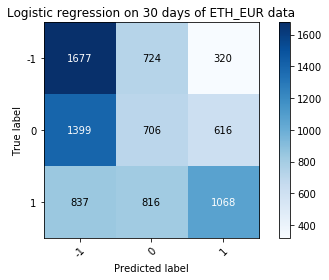

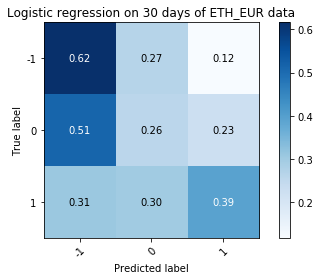

In [12]:
te.evaluate(X_test, Y_test, title="Logistic regression on 30 days of ETH_EUR data", dataset_name=dataset_name)

# Random Forest

In [13]:
# Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
te.set_model(clf)

te.fit(X_train,Y_train)

accuracy: 0.3980154355016538 %
precision: 0.3955885508774667 %
recall: 0.3980154355016538 %
f1_score: 0.3919361985072271 %



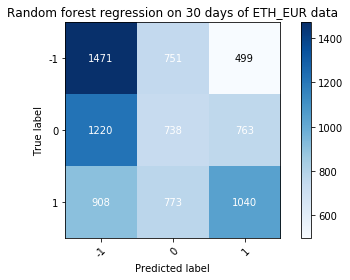

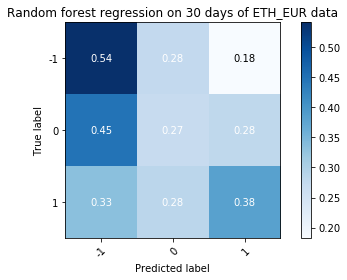

In [14]:
te.evaluate(X_test, Y_test, title="Random forest regression on 30 days of ETH_EUR data", dataset_name=dataset_name)

# Mean prediction baseline

We predict the movement using only the mean of historical data in a sliding window.

BASELINE PREDICTION BASED ON HISTORICAL MEAN 

accuracy: 0.5511954992967651 %
precision: 0.5718292494189678 %
recall: 0.5511954992967651 %
f1_score: 0.5577780379394939 %



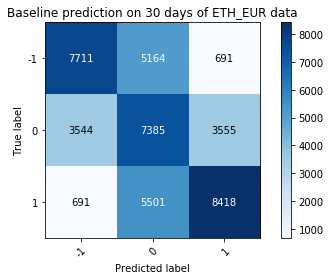

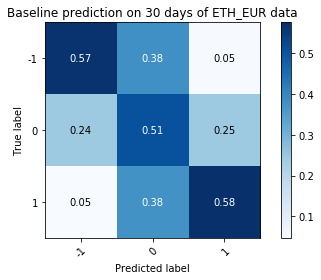

In [16]:
history_len = 40
alpha = 0.9

predictions = np.zeros([len(dataset)-history_len], dtype=[("label", int, 1)])

print("BASELINE PREDICTION BASED ON HISTORICAL MEAN", "\n")

# make predictions
for i in range(len(dataset)-history_len):
    vwap = dataset["vwap"][i+history_len]
    mean = np.mean(dataset["vwap"][i:i+history_len+1])
    volatility = calc_volatility(dataset["vwap"][i:i+history_len+1])
    
    threshold = volatility * alpha
    
    if mean - vwap < -threshold:
        predictions[i] = 1
    elif mean - vwap > threshold:
        predictions[i] = -1
    else:
        predictions[i] = 0

metrics = evaluate_result(dataset["label"][history_len:], predictions["label"])
for key in metrics:
    print(key + ":", metrics[key], '%')
print()
        
title = "Baseline prediction on 30 days of ETH_EUR data"      

# Plot non-normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], normalize=True, title=title)